A quick demo showing how MixDenoise works: we'll construct an
artificial GMM with 5 components and construct a MixDenoise
layer with 10 components.

We train on samples from the GMM and pass the resulting outputs
to some feedforward networks for dimensionality reduction from 10=>5,
and try to predict which gaussian it came from.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import the usual suspects:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from mixdenoise import MixDenoise, mdn_loss, regularized_mdn_loss

import numpy as np
from tqdm import tqdm, tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

- - - 

First, let's construct a function that samples from a Gaussian Mixture Model that will be unknown to our `MixDenoise` model.

In [3]:
### GMM sampling:
gmm_mixes = torch.Tensor([0.5, 0.5 ])
gmm_means = torch.Tensor([ 1.0, 2.0 ])
gmm_stdvs = torch.Tensor([ 0.1, 0.3 ])
def sample_from_gmm(size=1):
    """
    Return a batch of samples from above gaussian components.
    Output shape is (batch_size, 1).
    """
    # draw an integer vector of gaussian component choices:
    choices = torch.multinomial(gmm_mixes, size, replacement=True)
    # get corresponding gaussian samples:
    samples = torch.normal(gmm_means[choices], gmm_stdvs[choices])
    return (choices, samples)

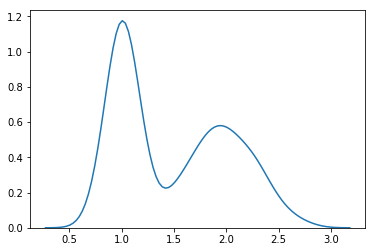

In [4]:
_choices, samples = sample_from_gmm(size=1000)
sns.kdeplot(samples.numpy())

- - -

Now, let's construct our `MixDenoise` model:

In [5]:
### MixDenoise model with 10 mixtures:
mdl = MixDenoise(3, jitter=0.5)
# warm-up the internal means:
mdl.means = nn.Parameter(torch.Tensor([0.0, 1.0, 2.0]), requires_grad=True)

`MixDenoise` exposes the following methods:
* `gmm()`: returns a 3-tuple of torch float variables `(pi, mu, sigma)` each of shape `(num_components,)`, representing the underlying mixture model.
* `sample(size=1)`: return `size` samples from the underlying GMM of the `MixDenoise` model.
* `activations(x)`: given `x ~ (batch_size,)`, return `activs ~ (batch_size, num_components)` giving the probability of each element of `x` against each component gaussian in the GMM.
* `forward(x)`: return the probability of sample `x ~ (batch_size,)` according to the underlying GMM density.

In [6]:
# Quick demo of sampling:
pi, mu, sigma = mdl.gmm()
print(pi)
print("-" * 40)
print(mu)
print("-" * 40)
print(sigma)

Variable containing:
 0.5420
 0.2102
 0.2478
[torch.FloatTensor of size 3]

----------------------------------------
Parameter containing:
 0
 1
 2
[torch.FloatTensor of size 3]

----------------------------------------
Variable containing:
 3.5864
 3.9001
 2.4379
[torch.FloatTensor of size 3]



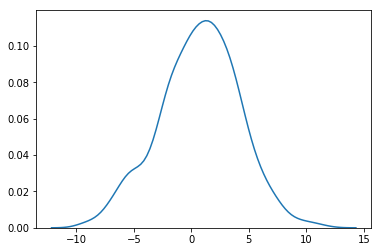

In [7]:
_, mdl_samples = mdl.sample(size=1000)
sns.kdeplot(mdl_samples.data.numpy())

- - -

Finally, let's train our model on the generated GMM samples:

In [8]:
# nb.: choosing a sufficiently small learning rate is important
opt = optim.Adam(mdl.parameters(), lr=0.00001)
def train(regularized=False):
    NUM_ITERS = 1000000
    PRINT_EVERY = 10000
    BSZ = 32
    for k in range(NUM_ITERS):
        # clear gradients:
        opt.zero_grad()
        # generate a sample:
        _, samps = sample_from_gmm(size=BSZ)
        x = Variable(samps)
        # compute loss:
        if not regularized:
            loss = mdn_loss(mdl(x))
        else:
            loss = regularized_mdn_loss(mdl, x)
        # backwards:
        loss.backward()
        opt.step()
        # print:
        if (k % PRINT_EVERY == 0): tqdm.write("{0} | {1}".format(k,loss.data[0]))

    # print weights:
    mdl_pi, mdl_mu, mdl_sigma = mdl.gmm()
    print("*** Learned weights:")
    print(mdl_pi.data)
    print("*** Learned means:")
    print(mdl_mu.data)
    print("*** Learned Stdvs:")
    print(mdl_sigma.data)

In [9]:
train()

0 | 2.1634585857391357
10000 | 2.054853677749634
20000 | 1.9269462823867798
30000 | 1.8224565982818604
40000 | 1.6999197006225586
50000 | 1.5809800624847412
60000 | 1.458940029144287
70000 | 1.3720247745513916
80000 | 1.2702478170394897
90000 | 1.1533395051956177
100000 | 1.0906963348388672
110000 | 1.0340349674224854
120000 | 0.8908693194389343
130000 | 0.9319125413894653
140000 | 0.8460730314254761
150000 | 0.8977468609809875
160000 | 0.8371689319610596
170000 | 0.825670063495636
180000 | 0.851169764995575
190000 | 0.7784522771835327
200000 | 0.736637532711029
210000 | 0.7784103155136108
220000 | 0.8390855193138123
230000 | 0.8282139897346497
240000 | 0.8365344405174255
250000 | 0.8830051422119141
260000 | 0.76194828748703
270000 | 0.730453372001648
280000 | 0.7762591242790222
290000 | 0.7731460928916931
300000 | 0.7310796976089478
310000 | 0.9138936996459961
320000 | 0.8225017786026001
330000 | 0.8756917119026184
340000 | 0.6558302044868469
350000 | 0.8512871861457825
360000 | 0.883

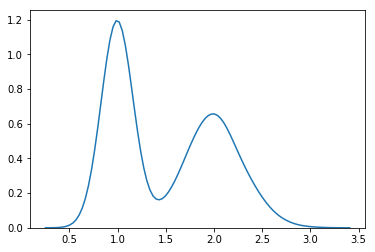

In [10]:
_, mdl_samples = mdl.sample(size=1000)
sns.kdeplot(mdl_samples.data.numpy())

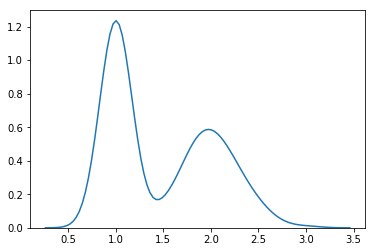

In [11]:
_choices, samples = sample_from_gmm(size=1000)
sns.kdeplot(samples.numpy())

- - - 

Finally, let's compare this with scikit-learn's Expectation-Maximization and Variational Bayes algorithms for gaussian mixture models.